In [ ]:
1.docker-compose 文件结构

In [ ]:
文件名的结构是：docker-compose.yaml 或者 docker-compose.yml,不要写成docker_compose!

In [ ]:
yaml文件结构：
version: "3"
services:
 
  redis:
    image: redis:alpine
    ports:
      - "6379"
    networks:
      - frontend
    deploy:
      replicas: 2
      update_config:
        parallelism: 2
        delay: 10s
      restart_policy:
        condition: on-failure
 
  db:
    image: postgres:9.4
    volumes:
      - db-data:/var/lib/postgresql/data
    networks:
      - backend
    deploy:
      placement:
        constraints: [node.role == manager]
 
  vote:
    image: dockersamples/examplevotingapp_vote:before
    ports:
      - 5000:80
    networks:
      - frontend
    depends_on:
      - redis
    deploy:
      replicas: 2
      update_config:
        parallelism: 2
      restart_policy:
        condition: on-failure
 
  result:
    image: dockersamples/examplevotingapp_result:before
    ports:
      - 5001:80
    networks:
      - backend
    depends_on:
      - db
    deploy:
      replicas: 1
      update_config:
        parallelism: 2
        delay: 10s
      restart_policy:
        condition: on-failure
 
  worker:
    image: dockersamples/examplevotingapp_worker
    networks:
      - frontend
      - backend
    deploy:
      mode: replicated
      replicas: 1
      labels: [APP=VOTING]
      restart_policy:
        condition: on-failure
        delay: 10s
        max_attempts: 3
        window: 120s
      placement:
        constraints: [node.role == manager]
 
  visualizer:
    image: dockersamples/visualizer:stable
    ports:
      - "8080:8080"
    stop_grace_period: 1m30s
    volumes:
      - "/var/run/docker.sock:/var/run/docker.sock"
    deploy:
      placement:
        constraints: [node.role == manager]
 
networks:
  frontend:
  backend:
 
volumes:
  db-data:

2.docker-compose使用示例
#通过docker-compose构建一个在docker中运行的基于python flask框架的web应用
#确保安装了Docker Engine和Docker Compose，不需要安装Python或者Redis，二者由Docker image 提供。

In [ ]:
step1 定义python应用
#1. 创建工程目录
mkdir compose_test
cd compose_test
mkdir src # 源码文件夹
mkdir docker # docker配置文件夹
#目录结构如下
└── compose_test
    ├── docker
    │   └── docker-compose.yml
    ├── Dockerfile
    └── src
        ├── app.py
        └── requirements.txt

#2.在compose_test/src/目录下创建 python flask 应用 compose_test/src/app.py文件
from flask import Flask
from redis import Redis
app = Flask(__name__)
redis = Redis(host='redis', port=6379)
 
@app.route('/')
def hello():
    count = redis.incr('hits')
    return 'Hello World! I have been seen {} times.\n'.format(count)
 
if __name__ == "__main__":
    app.run(host="0.0.0.0", debug=True)

#3.创建python 依赖文件 compose_test/src/requirements.txt
flask
redis

In [ ]:
step2 创建容器的Dockerfile文件
#一个文件一个Dockerfile文件，在compose_test/目录中创建Dockerfile文件
FROM python:3.7
COPY src/ /opt/src
WORKDIR /opt/src
RUN pip install -r requirements.txt
CMD ["python","app.py"]
#Dockerfile文件信息：
-从Python 3.7的镜像开始构建一个容器镜像。 
-复制src（即compose_test/src）目录到容器中的/opt/src目录。 
-将容器的工作目录设置为/opt/src（通过docker exec -it your_docker_container_id bash 进入容器后的默认目录）。 
-安装Python依赖关系。
-将容器的默认命令设置为python app.py。

In [ ]:
step3 定义docker-compose脚本
#在compose_test/docker/目录下创建docker-compose.yml文件，并在里面定义服务，内容如下：
version: '3'
  services:
    web:
        build: ../
        ports:
          - "5000:5000"
    redis:
        image: redis:3.0.7
这个compose文件定义了两个服务，即web和redis两个容器。
web容器：使用当前 docker-compose.yml 文件所在目录的上级目录（compose_test/Dockerfile）中的Dockerfile构建镜像；定义端口映射，使用了Flash Web服务器的默认端口。
redis容器：使用从DockerHub提取的官方redis镜像3.0.7版本。

In [ ]:
step4 使用Compose构建并运行应用程序
# 在compose_test/docker/ 目录下执行 docker-compose.yml 文件
docker-compose up # 如果需要后台运行，则 docker-compose up -d
# 如果不使用默认的 docker-compose.yml 文件名
docker-compose -f server.yml up -d
# 因为是在主机运行，所以可以通过浏览器输入 https://127.0.0.1:5000/ 查看运行的应用程序
参数解释：
-f 是 --file 的缩写，用来制定要使用的compose配置文件，默认情况下，docker-compose会查找当前目录下的docker-compose.yml 文件，
   如果要使用其他名称的配置文件，比如 service.yml 或者配置文件位于其他路径，则需要调用 -f 显式指定该配置文件。
-up 是 docker-compose 的启动服务指令，-d 表示后台（detach）模式；
其他常见缩写：-p 是 --project-name 的缩写，用来制定项目名称。

In [ ]:
step5 编辑 compose 文件以添加文件绑定挂载
上面的代码是在构建Dockerfile时静态复制到容器中的，即通过Dockerfile文件中的COPY src /opt/src 命令实现物理主机中的源码复制到容器中，这样后续物理主机src目录中的代码更改不会反应到容器中。
可以通过volumes关键字实现物理主机目录挂载到容器中的功能（删除Dockerfile中的COPY指令，即不需要在创建镜像时将代码打包进去，而是通过volums动态挂载，container和HOST共享数据卷）。
version: '3'
services:
  web:
    build: ../
    ports:
     - "5000:5000"
    volumes:
     - ../src:/opt/src
  redis:
    image: "redis:3.0.7"
通过volumes（卷）将主机上的项目目录（compose_test/src）挂载到容器中的/opt/src目录，允许即时修改代码，而无需重新构建镜像。

In [ ]:
step6 重新构建和运行应用程序
# 使用更新的compose文件构建应用程序，然后运行
docker-compose up -d

In [ ]:
3 compose 常用服务配置参考
Compose文件是一个定义服务，网络和卷的YAML文件。 
Compose文件的默认文件名为 docker-compose.yml 和 docker-compose.yaml.
如果在 Dockerfile 中指定了的选项（比如 CMD，EXPOSE，VOLUME，ENV）都会在运行 docker-compose 时遵守，因此不需要在 docker-compose.yml 中再次指定。
支持类似 Bash 的 ${VARIABLE} 语法在配置值中使用环境变量。

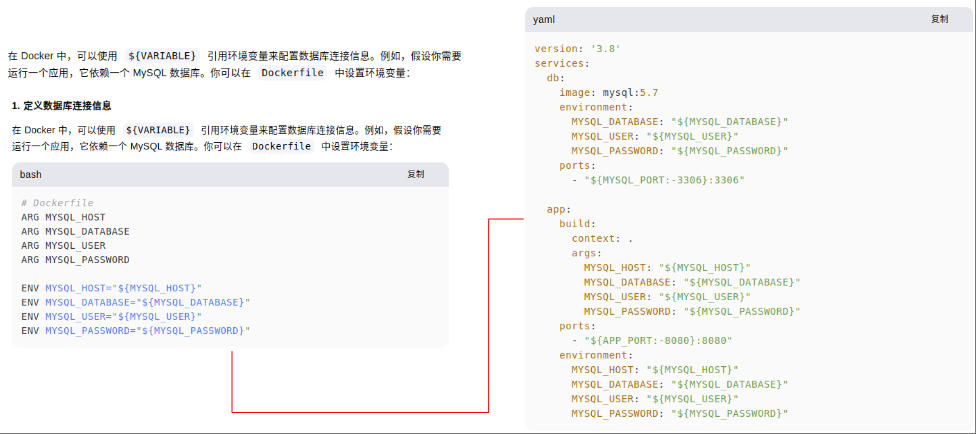

In [1]:
# ${VARIABLE}语法示例
from IPython.display import Image
Image(filename="dockerfile_variable.jpg",width=800,height=800)

In [ ]:
${VARIABLE}的其他用法
# 端口
version: '3.8'
services:
  web:
    image: nginx
    ports:
      - "${HOST_PORT:-8080}:80"
# 日志
version: '3.8'
services:
  app:
    image: myapp
    environment:
      LOG_LEVEL: "info"
      LOG_FILE_PATH: "${LOG_DIR}/application.log"

In [ ]:
（1）配置-build
1）build可以指定包含构建上下文的路径：
version: '2'
services:
    webapp:
        build: ./dir
2）或者作为一个对象，该对象具有上下文路径和指定的Dockerfile文件以及args参数值：
version: '2'
services:
  webapp:
    build:
      context: ./dir
      dockerfile: Dockerfile-alternate
      args:
        buildno: 1
这意味着webapp服务将会通过./dir目录下的Dockerfile-alternate文件构建容器镜像。
3）如果同时指定image和build，则compose会通过build指定的目录构建容器镜像，而构建的镜像名为image中指定的镜像名和标签。
build ./dir
image: webapp:tag
即，由./dir构建名为webapp、标记为tag的镜像。

In [ ]:
（2）配置-context
context包含Dockerfile文件的目录路径，或者是git仓库的URL。
当提供的值是相对路径时，表示相对于当前compose文件的位置。 该目录也是发送到Docker守护程序构建镜像的上下文。

In [ ]:
（3）配置-dockerfile
备用Docker文件。Compose将使用备用文件来构建，此外需要指定构建路径。

In [ ]:
（4）配置-args
args 用来添加构建镜像的参数，环境变量只能在构建过程中访问。
#首先在Dockerfile中指定要使用的参数
ARG buildno
ARG password
 
RUN echo "Build number: $buildno"
RUN script-requiring-password.sh "$password"
#在args键下指定参数，传递映射（数组）或者列表
build:
  context: .
  args:
    buildno: 1
    password: secret
 
build:
  context: .
  args:
    - buildno=1
    - password=secret
** 注意：YAML布尔值（true，false，yes，no，on，off）必须用引号括起来，以便解析器将它们解释为字符串

In [ ]:
（5）配置-image
用来指定启动容器的镜像，可以是镜像仓库/标签或者镜像id（或者id的前一部分）
image: redis
image: ubuntu:14.04
image: tutum/influxdb
image: example-registry.com:4000/postgresql
image: a4bc65fd
如果镜像不存在，Compose将尝试从官方镜像仓库pull下来，如果进一步指定了build，那么Compose将使用指定的build选项来构建，并使用image指定的名字和标记。

In [ ]:
（6）配置-container_name
指定一个自定义容器名称，而不是生成的默认名称。
container_name: my-web-container
**注意，由于Docker容器名称必须是唯一的，因此如果指定了自定义名称，则无法将服务扩展到多个容器。

In [ ]:
（7）配置-volumes
卷挂载路径设置。可以设置宿主机路径 （HOST:CONTAINER） 或加上访问模式 （HOST:CONTAINER:ro）,挂载数据卷的默认权限是读写（rw），可以通过ro指定为只读。
可以在主机上挂载相对路径，该路径将相对于当前正在使用的Compose配置文件的目录进行扩展。 
相对路径应始终以 "." 或者 ".." 开始。
volumes:
  # 只需指定一个路径，让引擎创建一个卷
  - /var/lib/mysql
  # 指定绝对路径映射
  - /opt/data:/var/lib/mysql 
  # 相对于当前compose文件的相对路径
  - ./cache:/tmp/cache 
  # 用户家目录相对路径
  - ~/configs:/etc/configs/:ro 
  # 命名卷
  - datavolume:/var/lib/mysql
如果要跨多个服务并重用挂载卷，最好在顶级volumes关键字中命名挂载卷。但是要注意，通过顶级volumes定义一个挂载卷，并从每个服务的卷列表中引用它， 这会替换早期版本的Compose文件格式中volumes_from。
version: "3" 
services:
  db:
    image: db
    volumes:
      - data-volume:/var/lib/db
  backup:
    image: backup-service
    volumes:
      - data-volume:/var/lib/backup/data 
volumes:
  data-volume:

In [ ]:
（8）配置-command
覆盖容器启动后默认的执行的命令。
    command: bundle exec thin -p 3000
该命令可以是一个类似于 dockerfile 的列表：
    commands: ["bundle", "exec", "thin", "-p", "3000"]

In [ ]:
 (9) 配置-links
用来链接到另一个服务中的容器。需要指定服务名称和链接别名（SERVICES：ALIAS），或者仅指定服务名称。
web:
  links:
   - db
   - db:database
   - redis
在当前的web服务的容器中可以通过链接的db服务的别名database访问db容器中的数据库应用，如果没有指定别名，则可直接使用服务名访问。
链接不需要启用服务进行通信 - 默认情况下，任何服务都可以以该服务的名称到达任何其他服务。 （实际是通过设置/etc/hosts的域名解析，从而实现容器间的通信。故可以像在应用中使用localhost一样使用服务的别名链接其他容器的服务，前提是多个服务容器在一个网络中可路由联通）
links也可以起到和depends_on相似的功能，即定义服务之间的依赖关系，从而确定服务启动的顺序。

In [ ]:
（10）配置-external_links
链接到docker-compose.yml 外部的容器，甚至并非 Compose 管理的容器。参数格式跟 links 类似。
external_links:
 - redis_1
 - project_db_1:mysql
 - project_db_1:postgresql

In [ ]:
（11）配置-expose
暴露端口，但与port不同，expose不映射到宿主机，只被连接的服务访问。
因此仅可以指定内部端口为参数：
expose:
    - "3000"
    - "8000"

In [ ]:
 (12) 配置-ports
暴露端口。格式：使用宿主：容器（HOST：CONTAINER）；或者仅仅指定容器的端口（宿主将会随机选择端口）都可以。
** 注意：当使用 HOST:CONTAINER 格式来映射端口时，如果使用的容器端口小于 60 可能会得到错误得结果，因为 YAML 将会解析 xx:yy 这种数字格式为 60 进制。所以建议采用字符串格式。
1）简单的短格式
ports:
 - "3000"
 - "3000-3005"
 - "8000:8000"
 - "9090-9091:8080-8081"
 - "49100:22"
 - "127.0.0.1:8001:8001"
 - "127.0.0.1:5000-5010:5000-5010"
 - "6060:6060/udp"
2）长格式语法允许配置短格式无法表示的附加字段
ports:
  - target: 80
    published: 8080
    protocol: tcp
    mode: host
-target: 容器内的端口
-published: 物理主机的端口
-protocol: 端口协议（tcp或udp）
-mode: host 和 ingress 两种模式，host用于在每个节点上发布主机端口，ingress用于被负载平衡的swarm模式端口。

In [ ]:
（13）配置-restart
重启策略默认为"no"，在任何情况下都不会重启容器。 
指定为always时，容器总是重新启动。 
如果退出代码指示出现故障错误，则on-failure将重新启动容器。
restart: "no"
restart: always
restart: on-failure
restart: unless-stopped

In [ ]:
（14）配置-environment
用来添加环境变量。
可以使用数组或者字典两种形式。任何布尔值; true，false，yes，no需要用引号括起来，以确保它们不被YML解析器转换为True或False。
只给定名称的变量会自动获取它在 Compose 主机上的值，可以用来防止泄露不必要的数据。
environment:
  RACK_ENV: development
  SHOW: 'true'
  SESSION_SECRET:
 
environment:
  - RACK_ENV=development
  - SHOW=true
  - SESSION_SECRET
** 注意：如果服务指定了build选项，那么在构建过程中通过environment定义的环境变量将不会起作用。 将使用build的args子选项来定义构建时的环境变量。

In [ ]:
（15）配置-pid
将PID模式设置为主机PID模式。 
这就打开了容器与主机操作系统之间的共享PID地址空间。 
使用此标志启动的容器将能够访问和操作裸机的命名空间中的其他容器，反之亦然。即打开该选项的容器可以相互通过进程 ID 来访问和操作。
    pid: "host"

In [ ]:
(16) 配置-dns
配置 DNS 服务器。可以是一个值，也可以是一个列表。
dns: 8.8.8.8
dns:
  - 8.8.8.8
  - 9.9.9.9